In [8]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# Model
We can load a pre-trained CNN directly through Keras. We choose VGG16, which consists of convolutional and pooling layers first, followed by a few fully connected (dense) layers.

In [9]:
base_model = VGG16(weights='imagenet')
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

We define a model that omits the last layer of the VGG16 net, so we can use it to obtain feature vectors for any given input image.

In [10]:
fc2_model = Model(inputs=base_model.input, outputs=base_model.get_layer("fc2").output)

# Image examples
Let's look at a few example images. We load the image, transform it to a numpy array, and preprocess it for use with VGG16. We store the intermediate steps in dictionaries, for demonstrative purposes.

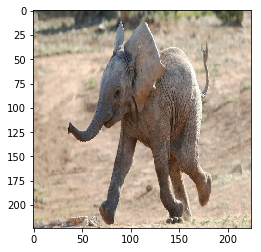

Predictions:
tusker, with probability: 0.37729907035827637
Indian_elephant, with probability: 0.24697431921958923
African_elephant, with probability: 0.24193653464317322
warthog, with probability: 0.039116088300943375
Komodo_dragon, with probability: 0.015973949804902077



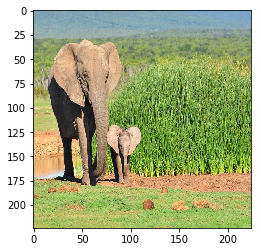

Predictions:
African_elephant, with probability: 0.8334344029426575
tusker, with probability: 0.14022447168827057
Indian_elephant, with probability: 0.022295458242297173
Arabian_camel, with probability: 0.003669393714517355
bison, with probability: 0.00012929007061757147



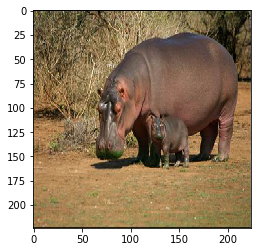

Predictions:
hippopotamus, with probability: 0.9996416568756104
water_buffalo, with probability: 0.00029096679645590484
warthog, with probability: 2.7117193894810043e-05
hog, with probability: 2.0470772142289206e-05
Indian_elephant, with probability: 6.381444563885452e-06



In [12]:
def load_img_preprocess(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    array = image.img_to_array(img)
    x = np.expand_dims(array, axis=0)
    x = preprocess_input(x)
    return {"img": img, "array": array, "x": x}

elephant1 = load_img_preprocess('images/elephant1.jpg')
elephant2 = load_img_preprocess('images/elephant2.jpg')
hippo1 = load_img_preprocess('images/hippo1.jpg')

def show_image_predictions(img_obj):
    plt.imshow(img_obj["img"])
    plt.show()
    preds = base_model.predict(img_obj["x"])
    preds_dec = decode_predictions(preds, top=5)[0]
    print("Predictions:")
    for pred in preds_dec:
        print("{}, with probability: {}".format(pred[1],pred[2]))
    print("")

show_image_predictions(elephant1)
show_image_predictions(elephant2)
show_image_predictions(hippo1)

Let's use the fc2_model to obtain feature vectors for our example images, and include them in the dictionaries.

In [5]:
def include_features(img_obj):
    img_obj["fc2"] = fc2_model.predict(img_obj["x"])
    
include_features(elephant1)
include_features(elephant2)
include_features(hippo1)

In [6]:
elephant1["x"].shape[1:]

(224, 224, 3)

We can compare two images (as matrices) or feature vectors by computing the average (squared) distance elementwise. Let's do this for our example images.

In [7]:
# mean L1-distance (mean absolute error)
def mae(a,b):
    return np.absolute(a-b).mean(axis=None)
    
# mean squared L2-distance (mean squared error)
def mse(a,b):
    return ((a-b)**2).mean(axis=None)

print("fc2 feature vectors:")
print(mse(elephant1["fc2"], elephant2["fc2"]))
print(mse(elephant1["fc2"], hippo1["fc2"]))
print(mse(elephant2["fc2"], hippo1["fc2"]))
print("")
print(mae(elephant1["fc2"], elephant2["fc2"]))
print(mae(elephant1["fc2"], hippo1["fc2"]))
print(mae(elephant2["fc2"], hippo1["fc2"]))
print("")
print("original images as 224x224 matrices:")
print(mse(elephant1["array"].flatten(), elephant2["array"].flatten()))
print(mse(elephant1["array"].flatten(), hippo1["array"].flatten()))
print(mse(elephant2["array"].flatten(), hippo1["array"].flatten()))
print("")
print(mae(elephant1["array"].flatten(), elephant2["array"].flatten()))
print(mae(elephant1["array"].flatten(), hippo1["array"].flatten()))
print(mae(elephant2["array"].flatten(), hippo1["array"].flatten()))

fc2 feature vectors:
1.7509232
3.639326
4.3795094

0.64952445
0.8891065
1.0290319

original images as 224x224 matrices:
5055.962
6039.2397
4578.4795

56.93345
64.73752
54.445904


Observe that when using the feature vectors, the first two images (both elephants) are considered "more similar" according to these distance measures. Looking at the original images as 224x224 matrices however, the first elephant is more similar to the hippo, according to these distance measures.